In [1]:
# imports
import os, sys

# third party imports
import numpy as np
import tqdm
import pandas as pd
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

2023-10-30 09:50:56.827345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-30 09:50:57.047222: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-30 09:50:57.048822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 09:50:58.754707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Conform test data.
def conform(x, in_shape = (256,) * 2):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))

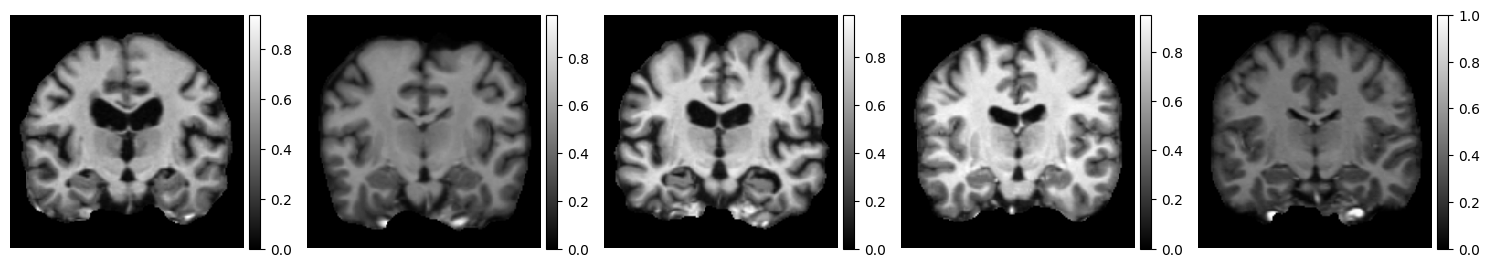

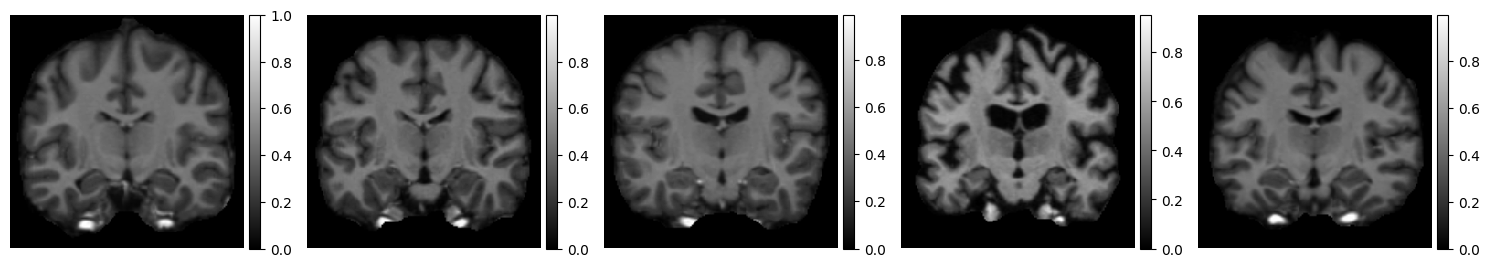

In [3]:
#Loading the dataset
images = ne.py.data.load_dataset('2D-OASIS-TUTORIAL')
conformed_images = [conform(img) for img in images]
#label_maps_real = [(img*15).astype('int').reshape(256, 256) for img in conformed_images]
label_maps_real = [img.reshape(256, 256) for img in conformed_images]


# Visualizing the dataset.
num_row = 2
per_row = 5
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps_real[i:i + per_row], cmaps=['gray'], do_colorbars=True)

In [7]:
#Fixing data + spliting

#conversion of labels in range of [0,1]
label_maps_real = np.array(label_maps_real)
# label_maps_synth = np.array(label_maps_synth)
#label_maps_real = label_maps_real.astype('float')/15
#label_maps_synth = label_maps_synth.astype('float')/15
#label_maps_hy = np.zeros((250, 256, 256))
#label_maps_hy[::2] = [i for i in label_maps_real[:125, ...]]
#label_maps_hy[1::2] = [i for i in label_maps_synth[:125, ...]]
#label_maps_hy = np.array(label_maps_hy)

#data split 
Data_split_train = 250
real_train = label_maps_real[:250, ...]
# few_shot_train = label_maps_real[:50, ...]
test_val_no = 82
real_val = label_maps_real[250:332, ...]
real_test = label_maps_real[-82:, ...]

In [10]:
def vxm_data_generator_real(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [11]:
batch_size = 16

In [12]:
val_generator = vxm_data_generator_real(real_test, batch_size = batch_size)
val_input, _ = next(val_generator)